In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#Load the data.
train = pd.read_json("input/train.json")
target_train = np.array(train['is_iceberg'])
test = pd.read_json("input/test.json")

In [3]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [4]:
train.inc_angle = train.inc_angle.replace('na', 0)
idx_tr = np.where(train.inc_angle > 0)

In [5]:
Y_train = target_train[idx_tr[0]]
X_train = X_train[idx_tr[0],...]

---


In [6]:
# import cv2
# def get_more_images(imgs):
    
#     more_images = []
#     vert_flip_imgs = []
#     hori_flip_imgs = []
      
#     for i in range(0,imgs.shape[0]):
#         a=imgs[i,:,:,0]
#         b=imgs[i,:,:,1]
#         c=imgs[i,:,:,2]
        
#         av=cv2.flip(a,1)
#         ah=cv2.flip(a,0)
#         bv=cv2.flip(b,1)
#         bh=cv2.flip(b,0)
#         cv=cv2.flip(c,1)
#         ch=cv2.flip(c,0)
        
#         vert_flip_imgs.append(np.dstack((av, bv, cv)))
#         hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
#     v = np.array(vert_flip_imgs)
#     h = np.array(hori_flip_imgs)
       
#     more_images = np.concatenate((imgs,v,h))
    
#     return more_images

In [7]:
# X_train_more = get_more_images(X_train)

In [8]:
# Y_train_more = np.concatenate((Y_train, Y_train, Y_train))

---

In [9]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [10]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [11]:
# X_batch, y_batch = gen.flow(X_train, X_train, batch_size=batch_size)
# def gen_flow_for_two_inputs(X, y):
#     genX1 = gen.flow(X,y,  batch_size=batch_size,seed=55)
#     genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
#     while True:
#             X1i = genX1.next()
#             X2i = genX2.next()
#             #Assert arrays are equal - this was for peace of mind, but slows down training
#             #np.testing.assert_array_equal(X1i[0],X2i[0])
#             yield [X1i[0], X2i[1]], X1i[1]

In [29]:
#define our model
def getModel():
    #Building the model
    model=Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=(75, 75, 3)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, activation="relu", input_shape=(75, 75, 3)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())

    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(adam, "binary_crossentropy", metrics=["accuracy"])
    
    model.summary()
    return model

In [30]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)

In [31]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, Y_train, random_state=1, train_size=0.75)

In [38]:
model=getModel()

# histr = model.fit(X_train_cv, y_train_cv,
#           batch_size=24,
#           epochs=50,
#           verbose=1,
#           validation_data=(X_valid, y_valid),
#           callbacks=callbacks)

gen_flow = gen.flow(X_train_cv, y_train_cv)
histr = model.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=(X_valid, y_valid),
            callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
dropout_13 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 34, 34, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 64)                0         
__________

In [39]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_train_cv, y_train_cv, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1103/1103 [==============================] - 0s 254us/step
Train score: 0.317835671785
Train accuracy: 0.855847689042


In [40]:
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

368/368 [==============================] - 0s 244us/step
Test score: 0.3125035698
Test accuracy: 0.85597826087


In [41]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=model.predict_proba(X_test)

In [42]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('Model_00-DAug.csv', index=False)

dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])


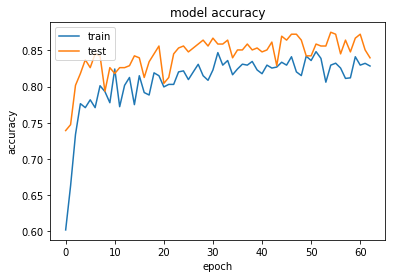

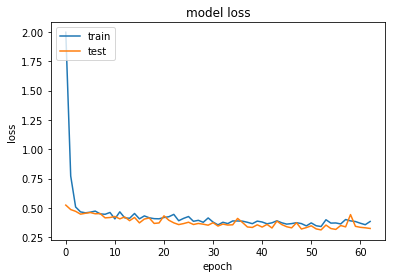

In [43]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()